In [21]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image
from sklearn.cluster import KMeans
from PIL import Image 
from collections import Counter
import json

import os
import glob
from tqdm.notebook import tqdm

OCR the text

In [2]:
!pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!pip install easydict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/GXYM/TextBPN-Plus-Plus.git
%cd /kaggle/working/TextBPN-Plus-Plus/model
!gdown 11AtAA429JCha8AZLrp3xVURYZOcCC2s1
!unzip '/kaggle/working/TextBPN-Plus-Plus/model/Totaltext.zip'
%cd /kaggle/working/TextBPN-Plus-Plus

Cloning into 'TextBPN-Plus-Plus'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 466 (delta 99), reused 88 (delta 88), pack-reused 358 (from 1)
Receiving objects: 100% (466/466), 12.75 MiB | 17.22 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/kaggle/working/TextBPN-Plus-Plus/model
Downloading...
From (original): https://drive.google.com/uc?id=11AtAA429JCha8AZLrp3xVURYZOcCC2s1
From (redirected): https://drive.google.com/uc?id=11AtAA429JCha8AZLrp3xVURYZOcCC2s1&confirm=t&uuid=8596d3f7-b8da-4592-9cd4-58822cac6d38
To: /kaggle/working/TextBPN-Plus-Plus/model/Totaltext.zip
100%|████████████████████████████████████████| 349M/349M [00:05<00:00, 64.6MB/s]
Archive:  /kaggle/working/TextBPN-Plus-Plus/model/Totaltext.zip
   creating: Totaltext/
  inflating: Totaltext/TextBPN_deformable_resnet50_480.pth  
  inflating: Totaltext/TextBPN_resnet18_570.pth  
  inflating: Totaltext/TextBPN_re

In [4]:
input_dir = '/kaggle/input/totaltext-preprocessing/data'
extra_cfg = {
    'net': 'resnet18',
    'scale': 4,
    'exp_name': 'Totaltext',
    'checkepoch': 570,
    'test_size': [640, 960],
    'gpu': '1',
    'dis_threshold': 0.35,
    'cls_threshold': 0.9,
    'viz': True,
    'img_root': input_dir,
    'resume': None,
    'num_workers': 24,
    'cuda': False,
    'mgpu': False,
    'save_dir': './model/',
    'vis_dir': './vis/',
    'log_dir': './logs/',
    'loss': 'CrossEntropyLoss',
    'pretrain': False,
    'verbose': True,
    'max_epoch': 250,
    'lr': 1e-3,
    'lr_adjust': 'fix',
    'stepvalues': [],
    'weight_decay': 0.0,
    'gamma': 0.1,
    'momentum': 0.9,
    'batch_size': 6,
    'optim': 'Adam',
    'save_freq': 5,
    'display_freq': 10,
    'viz_freq': 50,
    'log_freq': 10000,
    'val_freq': 1000,
    'load_memory': False,
    'rescale': 255.0,
    'input_size': 640,
    'start_epoch': 0
}

In [6]:
import os
import time
import cv2
import torch
import json
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from dataset.deploy import DeployDataset
from network.textnet import TextNet
from cfglib.config import config as cfg
from cfglib.option import BaseOptions
from util.augmentation import BaseTransform
from util.visualize import visualize_detection, visualize_gt
from util.misc import to_device, mkdirs,rescale_result

def update_config(cfg, extra_cfg):
    for k, v in extra_cfg.items():
        cfg[k] = v
        # print(config.gpu)
        cfg.device = torch.device('cuda') if cfg.cuda else torch.device('cpu')

def osmkdir(input_pth):
    import shutil
    from pathlib import Path
    
    if os.path.isdir(input_pth):
        return input_pth
    
    input_dir = '/kaggle/working/input_dir'
    if os.path.exists(input_dir):
        try:
            shutil.rmtree(input_dir)
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))
            
    os.makedirs(input_dir)
    
    new_path = os.path.join(input_dir, Path(input_pth).name)
    shutil.copy2(input_pth, new_path)  # Use copy2 to preserve metadata
    
    # Return the path of the new folder
    return input_dir

    

def heatmap_to_binary(heatmap, threshold=127):
    binary_image = np.where(heatmap[:,:, 0] >= threshold, 255, 0)
    
    return binary_image

def inference(model, test_loader):

    total_time = 0.
    art_results = {}
    for i, (image, meta) in enumerate(test_loader):
        input_dict = dict()
        idx = 0  # test mode can only run with batch_size == 1
        H, W = meta['Height'][idx].item(), meta['Width'][idx].item()
        print(meta['image_id'], (H, W))

        input_dict['img'] = to_device(image)

        # get detection result
        start = time.time()
        output_dict = model(input_dict)
#         print(output_dict["py_preds"])
        torch.cuda.synchronize()
        end = time.time()
        if i > 0:
            total_time += end - start
            fps = (i + 1) / total_time
        else:
            fps = 0.0

        print('detect {} / {} images: {}. ({:.2f} fps)'.
              format(i + 1, len(test_loader), meta['image_id'][idx], fps))

        # visualization
        img_show = image[idx].permute(1, 2, 0).cpu().numpy()
        img_show = ((img_show * cfg.stds + cfg.means) * 255).astype(np.uint8)
        
        gt_contour = []
        label_tag = meta['label_tag'][idx].int().cpu().numpy()
        for annot, n_annot in zip(meta['annotation'][idx], meta['n_annotation'][idx]):
            if n_annot.item() > 0:
                gt_contour.append(annot[:n_annot].int().cpu().numpy())

        gt_vis = visualize_gt(img_show, gt_contour, label_tag)
        show_boundary, heat_map = visualize_detection(img_show, output_dict, meta=meta)
#             file_path = os.path.join(cfg.vis_dir, meta['image_id'][idx].split(".")[0]+"_heat_map.json")
        np.set_printoptions(threshold=np.inf)
#             print(heat_map[:,:, 0])
        heatmap_binary = heatmap_to_binary(heat_map)
        show_map = np.concatenate([heat_map, gt_vis], axis=1)
        show_map = cv2.resize(show_map, (320 * 3, 320))
        im_vis = np.concatenate([show_map, show_boundary], axis=0)

        contours = output_dict["py_preds"][-1].int().cpu().numpy()
        img_show, contours = rescale_result(img_show, contours, H, W)
        p
        result = {
            'heatmap': heatmap_binary,
            'contours': contours
        }
#         print(result.keys())
        art_results[meta['image_id'][0]] = result
        
    return art_results

def extract_shape_text(input_pth):
#     if not os.path.isdir(input_pth):
        
    extra_cfg['img_root'] = osmkdir(input_pth)
    update_config(cfg, extra_cfg)
    testset = DeployDataset(
        image_root=cfg.img_root,
        transform=BaseTransform(size=cfg.test_size, mean=cfg.means, std=cfg.stds)
    )

    if cfg.cuda:
        cudnn.benchmark = True

    # Data
    test_loader = data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=cfg.num_workers)

    # Model
    model = TextNet(is_training=False, backbone=cfg.net)
    model_path = os.path.join(cfg.save_dir, cfg.exp_name,
                              'TextBPN_{}_{}.pth'.format(model.backbone_name, cfg.checkepoch))

    model.load_model(model_path)
    model = model.to(cfg.device)  # copy to cuda
    model.eval()
    with torch.no_grad():
        print('Start testing TextBPN++.')
        return inference(model, test_loader)

In [ ]:
# image_path = '/kaggle/input/query-test/test/img1099_1.jpg'
# image = Image.open(image_path)
# plt.imshow(image)
# plt.show()

# results = extract_shape_text(image_path)
# # results = {
# # image: {heat_map, contours}
# # }
# print(results)

In [ ]:
import json
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
# Specify the image directories

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Define the Model fỏ font embeđing
class ImageEmbeddingModel(nn.Module):
    def __init__(self, model_name='efficientnet_b3.ra2_in1k', embedding_dim=128):
        super(ImageEmbeddingModel, self).__init__()
        
        # Load the pre-trained EfficientNet model
        self.base_model = timm.create_model(model_name, pretrained=False)
        in_features = self.base_model.get_classifier().in_features
        self.base_model.fc = nn.Linear(in_features, 3)
        # Remove the classifier head (the final fully connected layer)
        
        self.base_model.classifier = nn.Identity()  # Remove the final classification head
#         print(self.base_model)
        # Add an embedding layer (linear transformation)
        self.embedding_layer = nn.Linear(in_features, embedding_dim)
        
        # Optionally load the pretrained weights from a .pt file (classification model)
        

    def forward(self, x):
        # Pass through EfficientNet-B3 backbone (without classifier)
        x = self.base_model(x)
        
        # Pass the output through the embedding layer
        x = self.embedding_layer(x)
        
        # Normalize the embeddings (L2 normalization)
        return F.normalize(x, p=2, dim=1)


# Create the model for image retrieval (embedding)
model = ImageEmbeddingModel(model_name='efficientnet_b3.ra2_in1k', embedding_dim=128).cuda()
# Define Loss and Optimizer
# print(model.base_model)
pretrained_model_path = '/kaggle/input/tripletloss-training/triplet_model.pth' 
checkpoint = torch.load(pretrained_model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the state dictionary into the model
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

In [ ]:
# Define the model for shape embedding

In [82]:
def get_shape_embedding(image_path):
    '''
    Viết hàm extract shape vô đây
    '''

def get_font_embedding(image_path):
    image = Image.open(image_path)
    input_image = transform(image).unsqueeze(0)
    input_tensor = input_image.to(device)
    with torch.no_grad():
        embedding = model(input_tensor).cpu()
        return embedding


In [ ]:
# def extract_embeddings_for_directory(image_dir, output_dir):
#     os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
#     for image_name in tqdm(os.listdir(image_dir), desc="Processing Images"):
#         image_path = os.path.join(image_dir, image_name)
#         if image_path.endswith(('jpg', 'jpeg', 'png')):  # Filter by image file types
#             embedding = get_style_embedding(image_path)
#             output_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.npy")
#             np.save(output_path, embedding.cpu().numpy())
# image_directory = '/kaggle/input/totaltext-preprocessing/data'
# output_directory = '/kaggle/working/embeddings'
# extract_embeddings_for_directory(image_directory, output_directory)

In [42]:
# from fastembed import TextEmbedding
from typing import List
# text_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
# from fastembed import ImageEmbedding
image_model = model

In [43]:
import easyocr
import cv2

def create_mask(image_path, bboxes):
    # Read the image to get its dimensions
    img = cv2.imread(image_path)
    height,width,_ = img.shape

    # Create a blank mask with the same dimensions as the image
    mask = np.zeros((height, width), dtype=np.uint8)

    # Draw the bounding box on the mask
    # bbox format: ((x1, y1), (x2, y2))
    for bbox in bboxes:
        bbox_tuples = [(coord[0], coord[1]) for coord in bbox]
        # Draw the polygon (bounding box) on the mask
        cv2.fillPoly(mask, np.array([bbox_tuples], dtype=np.int32), color=255) # -1 fills the rectangle

    # Save the mask as an image
#     print(mask.shape)
#     print(img.shape)
#     plt.imshow(mask)
#     plt.show()
    
    masked_img = cv2.bitwise_and(img, img, mask=mask)
#     print(masked_img.shape,type(masked_img))
#     print(masked_img)
#     plt.imshow(masked_img)
#     plt.show()

    return masked_img
def extract_text(image_path):
#     print(image_path)
    reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
    result = reader.readtext(image_path)
    texts = ""
    b_boxes = []
    for line in result:
        b_boxes.append(line[0])
        texts +=" " +line[1]
    masked_img = create_mask(image_path, b_boxes)
#     print(masked_img,texts)
    return masked_img,texts

In [44]:
# from fastembed import TextEmbedding
from typing import List
def read_image(path,to_float=False):
    img = Image.open(path)
    return img

def generate_features(image_path):
    img , text = extract_text(str(image_path))
    documents: List[str] = [text]
    embeddings_list = list(text_model.embed(documents))
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(img)
    plt.show()
    temp_image_path = 'temp_image.jpeg'
    img.save(temp_image_path)
    
    # Extract visual features using FastEmbed
    
    visual_feature = get_style_embedding(temo_image_path)
    
    # Optionally delete the temporary image file
    os.remove(temp_image_path)
#     print(visual_feature.shape)
    return visual_feature,embeddings_list[0]

In [45]:
base_image_path = '/kaggle/input/totaltext-preprocessing/data'
font_feature_paths = glob.glob('/kaggle/input/tripletloss-training/embeddings/*')
# feature_paths
font_feature_paths[:10]

['/kaggle/input/tripletloss-training/embeddings/img832.11.npy',
 '/kaggle/input/tripletloss-training/embeddings/img1211.1.npy',
 '/kaggle/input/tripletloss-training/embeddings/img183.22.npy',
 '/kaggle/input/tripletloss-training/embeddings/img826.11.npy',
 '/kaggle/input/tripletloss-training/embeddings/img1490.2.npy',
 '/kaggle/input/tripletloss-training/embeddings/img1154.9.npy',
 '/kaggle/input/tripletloss-training/embeddings/img179.2.npy',
 '/kaggle/input/tripletloss-training/embeddings/img967.5.npy',
 '/kaggle/input/tripletloss-training/embeddings/img1211.9.npy',
 '/kaggle/input/tripletloss-training/embeddings/img1083.13.npy']

In [26]:

# import os
# from tqdm import tqdm

# # Example list of filenames  # Replace with your actual filenames

# # Example list of documents (contents read from files)
# documents: List[str] = []
# for file_name in text_fea_paths:
#     with open(file_name, 'r', encoding='utf-8') as file:
#         documents.append(file.read())

# # Initialize the TextEmbedding model
# embedding_model = TextEmbedding()
# print("The model BAAI/bge-small-en-v1.5 is ready to use.")

# # Embedding each document and storing embeddings with filenames
# embeddings_with_filenames = []
# for i, embedding in tqdm(enumerate(embedding_model.embed(documents))):
#     embedding_filename = f"{os.path.basename(text_fea_paths[i])}_embedding.npy"
    
#     # Save the embedding to a .npy file
#     np.save(embedding_filename, embedding)
    
#     embeddings_with_filenames.append((os.path.basename(text_fea_paths[i]), embedding))

# # Example of accessing the first document's embedding and filename
# first_filename, first_embedding = embeddings_with_filenames[0]
# print(f"Filename: {first_filename}")
# print(f"Embedding vector shape: {first_embedding.shape}")

# # Now embeddings_with_filenames contains tuples of (filename, embedding_vector)
# # You can process or store these embeddings as needed


In [76]:
from tqdm import tqdm
import glob
def get_color_embedding(image_path, n_clusters= 2):
    image = cv2.imread(image_path)
    image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_test = np.where(image > 5, image, 0)
    
    # convert image to list pixels of image
    pixels = image_test.reshape(-1, 3)
#     print(pixels.shape)
    pixels = [x for x in pixels if sum(x) > 10]
    if len(pixels) == 0:
        colors = [[0,0,0], [0,0,0]]
        feature = [0,0,0,0,0,0,0,0]
        return feature
#     print(len(pixels))
    # clustering pixels follow color RGB
    kmeans = KMeans(n_init= 'auto', n_clusters=n_clusters, random_state=42)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    dist = Counter(kmeans.labels_)
#     propotion = [dist[0]/(dist[0]+dist[1]), dist[1]/(dist[0]+dist[1])]
    propotion = np.array(list(dist.values()))
    propotion = propotion/sum(propotion)
#     print(propotion)
    feature = np.array(colors/255)
    feature = np.column_stack((feature, propotion))
    embedding = feature.flatten()
    return embedding

In [119]:
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
import json
FONT_PATH = glob.glob('/kaggle/input/tripletloss-training/embeddings/*.npy')
COLOR_PATH = glob.glob('/kaggle/input/detect-color-totaltext/*.npy')
BASE_LIST = glob.glob('/kaggle/input/totaltext-preprocessing/data/*')
def safe_log(x):
    return np.log(np.clip(x, a_min=1e-10, a_max=None))  # Clip values to avoid log(0)

def calculate_sid(q, p):
    # Replace NaN and Inf values with finite numbers
    q = np.nan_to_num(q, nan=1e-10, posinf=1e-10, neginf=1e-10)
    p = np.nan_to_num(p, nan=1e-10, posinf=1e-10, neginf=1e-10)
    
    # Avoid division by zero by adding a small epsilon value
    epsilon = 1e-10
    q = q + epsilon
    p = p + epsilon
    
    # Calculate SID
    sid_qp = np.sum(q * safe_log(q / p))
    sid_pq = np.sum(p * safe_log(p / q))
    return sid_qp, sid_pq
def wassernstein_dis(a,b):
    a = np.squeeze(a)
    b = np.squeeze(b)
    return -wasserstein_distance(a,b)
def city_block(a,b):
    a = np.squeeze(a)
    b = np.squeeze(b)
    return -distance.cityblock(a,b)
    
def cosine_similarity(vector_a, vector_b):
    vector_a = np.squeeze(vector_a)
    vector_b = np.squeeze(vector_b)
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

#get_similarities = np.vectorize(get_similarity, signature='(n), (k) -> ()')

def get_similarity(image_path,feature_paths,embedding):
    sim = {}
    # print(feature_paths[:1])
    for path in feature_paths:
        feature_embedding = np.load(path)
        base_name = os.path.splitext(os.path.basename(path))[0]
        # Compute the city block (Manhattan) distance between embeddings
        style_similarity = cosine_similarity(embedding, feature_embedding)
        # print("sim_dict",base_name)
        # Append the result with extracted image and box IDs
        sim[base_name]= style_similarity
    return sim
    # sorted(sim, key=lambda x: x['style_sim'], reverse=True)
    
def merge_retrieved_lists(list1, relevance_scores1, list2, relevance_scores2, asc=True):
    # Combine the lists and relevance scores into tuples
    list1 = get_result_path(list1, vis_fea_paths)
    list2 = get_result_path(list2, text_fea_paths)
    combined_list1 = list(zip(list1, relevance_scores1))
    combined_list2 = list(zip(list2, relevance_scores2))

    # Create a dictionary to keep the product of relevance scores for each document
    relevance_dict = {}

    # Combine both lists and compute the product of relevance scores
    for doc_id, score in combined_list1:
        if doc_id in relevance_dict:
            relevance_dict[doc_id] *= score
        else:
            relevance_dict[doc_id] = score

    for doc_id, score in combined_list2:
        if doc_id in relevance_dict:
            relevance_dict[doc_id] *= score
        else:
            relevance_dict[doc_id] = score

    # Sort the dictionary items by relevance score in ascending or descending order
    sorted_docs = sorted(relevance_dict.items(), key=lambda item: item[1],reverse = asc)

    # Extract the document IDs from the sorted list
    final_list = [doc_id for doc_id, score in sorted_docs]

    return final_list

def retrieve_image(image_path,with_style=True,with_text=False):
    if with_style == True:
        font_embedding = get_font_embedding(image_path)
        color_embedding = get_color_embedding(image_path)
        font_sim = get_similarity(image_path,FONT_PATH,font_embedding)
        color_sim = get_similarity(image_path,COLOR_PATH,color_embedding)
        #shape_sim
        final_score = []
        for img_path in BASE_LIST:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            font_score = font_sim.get(img_name, 0)  
            color_score = color_sim.get(img_name, 0)
            final_score.append({
                'id':img_name,
                'sim':(font_score*6 + color_score*1)/7,
                'font_sim': font_score,
                'color_sim':color_score
                #shape_sim: 
            })
            # print("final dcit",img_name)
        ans = sorted(final_score, key=lambda x: x['sim'], reverse=True)
        # print(ans[:5])
        return  ans
            
def get_results(vis_paths,text_paths):
    vis_list = get_result_path(vis_paths,vis_fea_paths)
    text_list = get_result_path(text_paths,text_fea_paths)
    # print(vis_list[:10],text_list[:10])
    intersection = list(set(vis_list) & set(text_list))
    return intersection
def get_result_path(indexes,feature_paths):
    res_list = []
    for item in indexes:
#         print(len(feature_paths))
#         print(item)
        feature_path = feature_paths[item]
        image_name = os.path.basename(feature_path)
        image_name = image_name.split(".")[0] + "."
#         print(image_name)
        image_path = [image_path for image_path in image_paths if image_name in image_path]
#         print(image_path)
        res_list.append(image_path[0])
    return res_list
def plot_10_images(indexes,feature_paths=None):
    similar_image_paths = indexes
    if feature_paths != None:
        similar_image_paths = get_result_path(indexes,feature_paths)
    print('Top 10 Similar Images:')    
    _, _ = plt.subplots(2, 5, figsize = (50, 20))
    for i, image_path in enumerate(similar_image_paths[:10]):
        plt.subplot(2, 5, i+1)
        img = read_image(image_path)
        plt.title(os.path.basename(image_path))
        plt.imshow(img)
    plt.show()    

In [47]:
import os

file_path = '/kaggle/input/query-totaltext/img1398_1.jpg'
if os.path.exists(file_path):
    print("File exists.")
else:
    print("File does not exist or path is incorrect.")


File exists.


In [114]:
import matplotlib.pyplot as plt
import cv2
def visualize_results(results, base_path):
    # Limit to the first 5 results
    top_results = results[:10]
    
    plt.figure(figsize=(15, 10))  # Set the figure size for better visibility
    
    for i, result in enumerate(top_results):
        image_path = f"{base_path}/{result}.jpg"  # Create the image path
        img = Image.open(image_path)  # Open the image
        
        # Plot the image
        plt.subplot(2, 10, i + 1)  # Create a subplot for each image (1 row, 5 columns)
        plt.imshow(img)
        plt.title(f"Result {i+1}")
        plt.axis('off')  # Hide axis
        
    plt.show()
    
# Path to the sample image
sample_image_path = '/kaggle/input/query-test/test/img1291_2.jpg'

# Read the image using cv2
sample_image = Image.open(sample_image_path)
embedding = get_font_embedding(sample_image_path)
# results = get_similarity(sample_image_path,FONT_PATH,embedding)
results = retrieve_image(image_path)
# visualize_results(results,'/kaggle/input/totaltext-preprocessing/data')
# Display the image using matplotlib
plt.title('Query Image')
plt.imshow(sample_image)
plt.axis('off')  # Hide the axis
plt.show()
print()
# Generate features for the sample image

# Plot the top 10 images using their indexes and paths
# print("Style results")
# plot_10_images(vis_indexes, vis_fea_paths)
# text_sim, text_indexes = get_text_results(text_fea, text_fea_paths)
# indexes = merge_retrieved_lists(vis_indexes,vis_sim,text_indexes,text_sim)
# # Plot the top 10 images using their indexes and paths
# print("Text results:")
# plot_10_images(text_indexes, text_fea_paths)
# print("Combined results:")
# plot_10_images(indexes, None)



[{'id': 'img1286.2', 'sim': 0.8047985041300626, 'font_sim': 0.75125474, 'color_sim': 0.9654298043887503}, {'id': 'img1054.9', 'sim': 0.7910389909536866, 'font_sim': 0.72402596, 'color_sim': 0.9920780696039307}, {'id': 'img1017.2', 'sim': 0.7822166824187491, 'font_sim': 0.7211815, 'color_sim': 0.9653221940380946}, {'id': 'img1182.5', 'sim': 0.7802320192907717, 'font_sim': 0.7816361, 'color_sim': 0.776019720496522}, {'id': 'img1207.16', 'sim': 0.7592425442689232, 'font_sim': 0.7317583, 'color_sim': 0.841695287606546}]


FileNotFoundError: [Errno 2] No such file or directory: "/kaggle/input/totaltext-preprocessing/data/{'id': 'img1286.2', 'sim': 0.8047985041300626, 'font_sim': 0.75125474, 'color_sim': 0.9654298043887503}.jpg"

<Figure size 1500x1000 with 0 Axes>

image name:/kaggle/input/query-test/test/img542_1.jpg
Query img542_1 - Precision: 0.0
Query img542_1 - Recall: 0.0


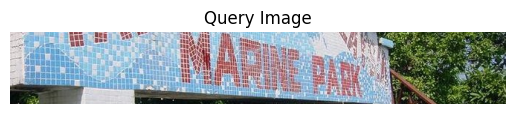

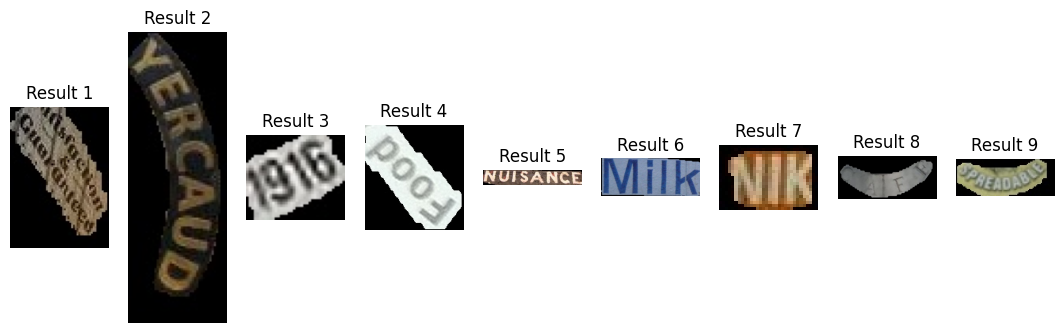

image name:/kaggle/input/query-test/test/img9_1.jpg
Query img9_1 - Precision: 0.0
Query img9_1 - Recall: 0.0


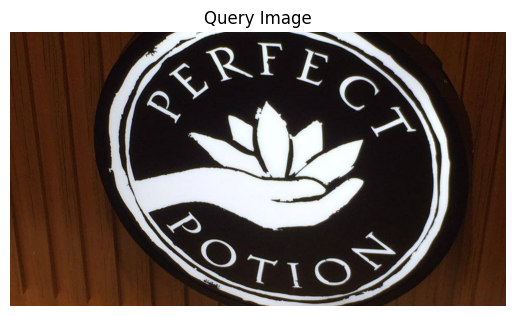

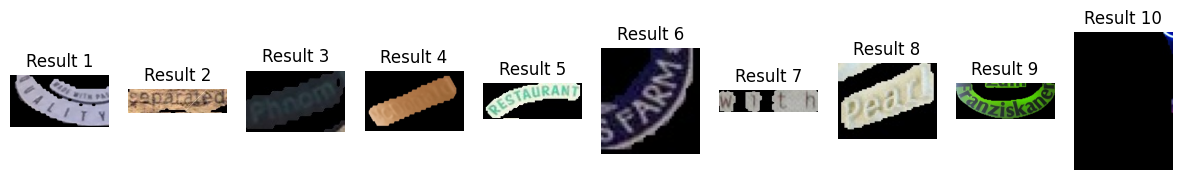

image name:/kaggle/input/query-test/test/img999_1.jpg
Query img999_1 - Precision: 0.0
Query img999_1 - Recall: 0.0


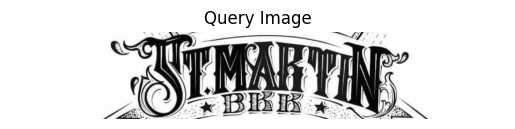

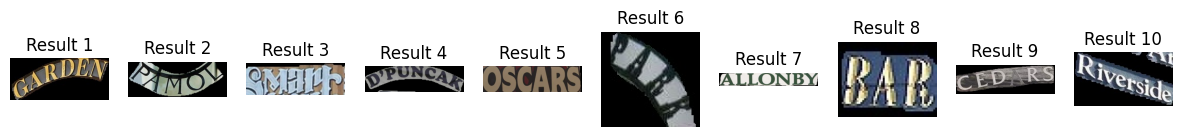

image name:/kaggle/input/query-test/test/img601_1.jpg
Query img601_1 - Precision: 0.0
Query img601_1 - Recall: 0.0


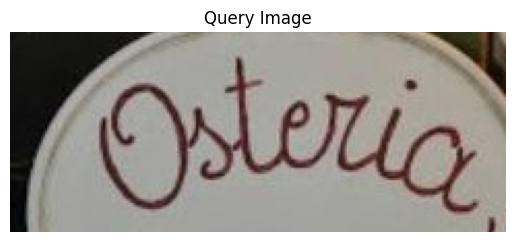

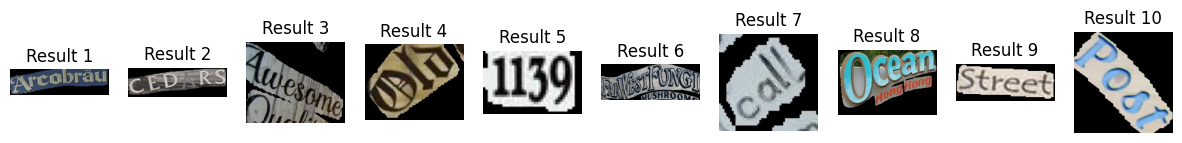

image name:/kaggle/input/query-test/test/img5_1.jpg
Query img5_1 - Precision: 0.1
Query img5_1 - Recall: 0.0625


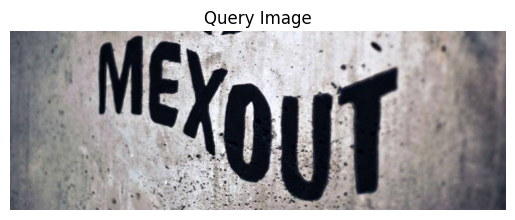

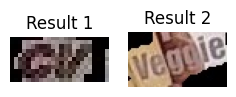

image name:/kaggle/input/query-test/test/img586_1.jpg
Query img586_1 - Precision: 0.0
Query img586_1 - Recall: 0.0


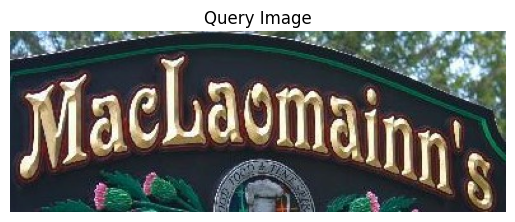

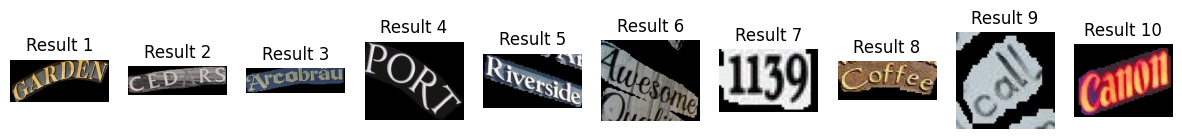

image name:/kaggle/input/query-test/test/img1197_1.jpg
Query img1197_1 - Precision: 0.2
Query img1197_1 - Recall: 0.07142857142857142


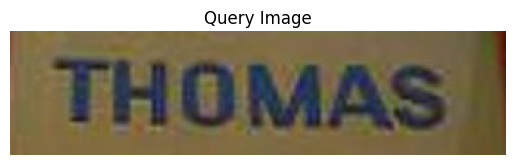

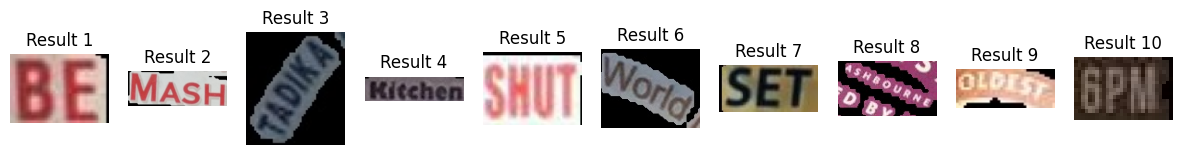

image name:/kaggle/input/query-test/test/img654_1.jpg
Query img654_1 - Precision: 0.0
Query img654_1 - Recall: 0.0


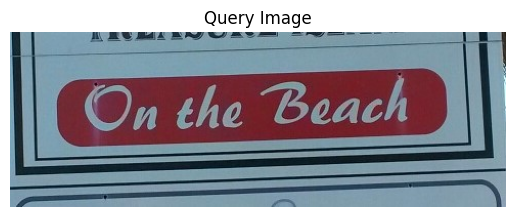

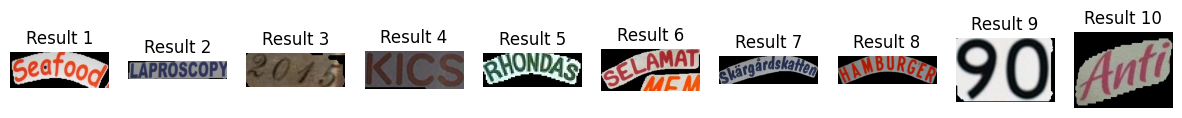

image name:/kaggle/input/query-test/test/img643_1.jpg
Query img643_1 - Precision: 0.0
Query img643_1 - Recall: 0.0


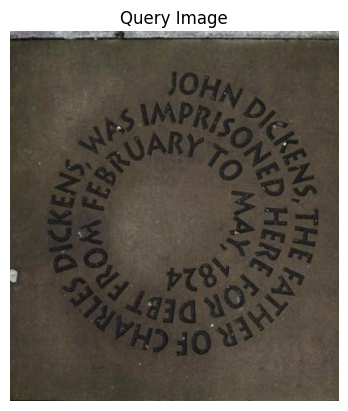

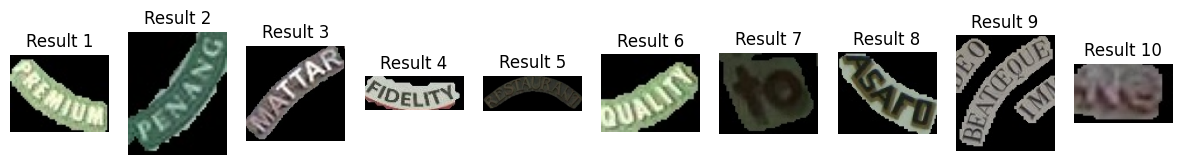

image name:/kaggle/input/query-test/test/img1542_1.jpg
Query img1542_1 - Precision: 0.0
Query img1542_1 - Recall: 0.0


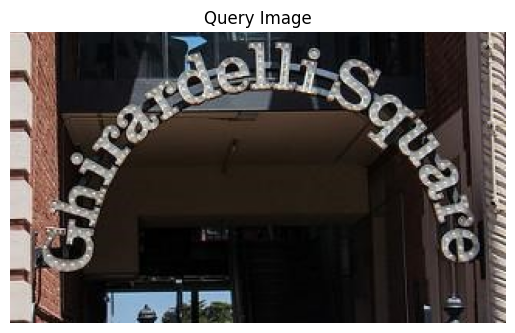

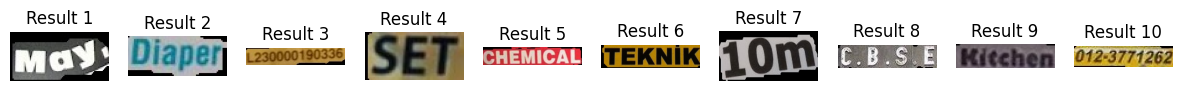

0.0030000000000000005

In [121]:
def recall_at_k(relevant_items, retrieved_items, k):
    """Calculate Recall@K"""
    relevant_retrieved = [item for item in retrieved_items[:k] if item in relevant_items]
    return len(relevant_retrieved) / len(relevant_items) if relevant_items else 0
def evaluate(sample_image_path, relevance_data):
    """ Evaluate the retrieval model on the query images. """
    # Load the query image embedding
    query_img = os.path.basename(sample_image_path).split('.')[0]  # Extract image name from path
    relevant_images = relevance_data.get(query_img, {})
    # Compute similarities between query and database embeddings
    # print(feature_paths[:10])
    similarities = retrieve_image(sample_image_path)
    # print(similarities)
    sample_image = Image.open(sample_image_path)
    
    # Extract the top K similar images and their similarity scores
    top_k = 10  # You can adjust this
    top_k_results = similarities[:top_k]
    # print(similarities[:1])
    filtered_results = [result['id'] for result in similarities if result['sim'] > 0.6]

    # relevant_set = set(relevant_images.keys())  # Set of relevant images
    retrieved_images = [img['id'].split('.')[0] for img in top_k_results]  # Top-k retrieved images
    # print(retrieved_images)
    relevant_set = set(img_id.split('.')[0] for img_id, score in relevant_images.items() if score > 2)

    # Compute Precision at the threshold (no fixed k now)
    precision_at_threshold = len(set(retrieved_images) & relevant_set) / len(retrieved_images) if retrieved_images else 0

    recall_at_threshold = recall_at_k(relevant_set, retrieved_images, len(retrieved_images))
    # Compute Precision at K as the fraction of relevant images in the top-k retrieved results
    # precision_at_k = len(set(retrieved_images[:top_k]) & relevant_set) / top_k
    # recall = recall_at_k(relevant_set,retrieved_images,top_k)
    # print(f"Precision at {top_k}:{precision_at_k}")
    # print(f"Recall at {top_k}= {recall}")
    print(f"Query {query_img} - Precision: {precision_at_threshold}")
    print(f"Query {query_img} - Recall: {recall_at_threshold}")
    plt.title('Query Image')
    plt.imshow(sample_image)
    plt.axis('off')  # Hide the axis
    plt.show()

    visualize_results(filtered_results,'/kaggle/input/totaltext-preprocessing/data')
    return precision_at_threshold, filtered_results
    # return precision_at_k, top_k_results

def load_relevance_data(json_path):
    """ Load the relevance data from the JSON file. """
    with open(json_path, 'r') as f:
        return json.load(f)
def evaluate_all_queries(query_images ,relevance_data):
    """ Evaluate the retrieval model on all queries in the dataset. """
    total_precision_at_k = 0
    total_queries = len(query_images)
    
    # Store results for all queries,
    query_results = {}
    
    for query_img in query_images[:10]:
        print(f"image name:{query_img}")
        precision_at_k, top_k_results = evaluate(query_img, relevance_data)
        total_precision_at_k += precision_at_k
        
        # Store individual results for each query
        query_results[query_img] = {
            'precision_at_k': precision_at_k,
            'top_k_results': top_k_results
        }
    
    # Calculate the average Precision at K across all queries
    mean_precision_at_k = total_precision_at_k / total_queries
    return mean_precision_at_k

relevance_json_path = '/kaggle/input/relevant/relevant.json'  # Path to the relevance data
relevance_data = load_relevance_data(relevance_json_path)
query_images = glob.glob('/kaggle/input/query-test/test/*')
# print(query_images[:10])
# Evaluate the model for the query image
evaluate_all_queries(query_images, relevance_data)



In [105]:
%matplotlib inline
